# Tutorial 2: Surrogate modelling with Kriging

A major issue in Uncertainty Quantification is the high-cost of evaluating the computational model one time (e.g. a CFD code) - combined with the large number of evaluations needed.  *Surrogate modelling* is a general term, describing replacing the CFD code with a cheap map that approximates it.  The polynomial stochastic methods are also surrogate models when used for interpolation (as opposed to quadrature).

With $d \in\mathbb{N}$ the number of parameters (the *dimension*), and a scalar output, any simulation code $g(\cdot)$ is schematically:
$$
g: \mathbb{R}^d\rightarrow \mathbb{R}
$$
to be approximated by a surrogate model $\hat g(\cdot)$:
$$
g(\mathbf{x}) \simeq \hat g(\mathbf{x}),\quad \mathbf{x}\in\Omega \subset \mathbb{R}^d.
$$

Surrogate models can be interpolative or regressive.  Some examples:

* Stochastic polynomial interpolants, including sparse-grids;
* Linear regression;
* Radial-basis function interpolation.

Our goal in this tutorial is to implement and explore the *stochastic* regressive surrogate model $\hat g$ called variously "Kriging" (by engineers) or "Gaussian Process Regression" (by mathematicians).  For simplicity will will consider the case $d=1$, but the generalization to higher-dimensions is striaghtforward.

We will consider the test-function
$$
g(x) = \sin(cx^2)\cdot (1+x) + (1+x^2),\quad c=40,
$$

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.stats as stats

c = 40
def g(x): return np.sin(x*x*c)*(1+x) + (1+x**2)

g-Mean: 1.4651525789495015, g-StdDev: 1.082548228747729


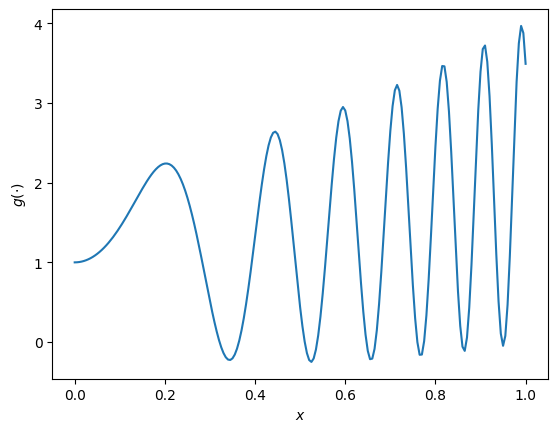

In [44]:
x = np.linspace(0, 1, 201)
plt.plot(x, g(x), '-')
plt.xlabel(r'$x$'); plt.ylabel(r'$g(\cdot)$')

g_mean = np.mean(g(x))
g_std = np.std(g(x))

print(f'g-Mean: {g_mean}, g-StdDev: {g_std}')

## Discretizing the domain $\Omega$
**EXERCISE 1**

Generate about $M=10$ *training nodes* randomly on $\Omega = [0,1]$ (e.g. with `np.random.rand()`), and additionally about $N=100$ *test nodes* uniformly spaced on $\Omega = [0,1]$.  Concatenate these arrays (e.g. with `np.hstack()`) to get a single array of both training and test nodes, "all".  To check your code `x_all.shape == (M+N,)` should be `True`.

In [45]:
M = 10
N = 100

x_train = np.sort(np.random.rand(M))
x_test = np.sort(np.random.rand(N))
x_all = np.hstack((x_train, x_test))

assert x_all.shape == (M+N,)

## Sampling from the prior

The first step is computing the prior covariance matrix based on the definition in the notes:
$$
[P]_{ij} := \sigma_y^2 r(x_i, x_j, l),\quad r(x_i,x_j,l) := \exp\left\{-\frac{|x_i-x_j|^2}{2 l^2}\right\}
$$
In the following code `r()` with array arguments `xi` and `xj`, computes the function $r()$ above, for all combinations of array entries, and returns the result in a matrix. 

In [46]:
def distances_all(xi,xj): 
    return np.abs(xi[np.newaxis,:] - xj[:,np.newaxis])

def r(xi, xj, sigma_0, l): 
    return sigma_0**2 * np.exp(-distances_all(xi,xj)**2/ l**2)

**EXERCISE 2**

Consider the Gaussian process $\mathcal{Y}_0$ defined by some mean function $\mu(x)$ and $r()$, written:
$$
\mathcal{Y}_0 \sim \mathcal{GP}(\mu, r).
$$
We know from the lectures that by selecting a finite vector of nodes $\mathbf{x} = (x_1,\dots,x_N)$, we can define a multivariate random variable $\mathbf{Y}_0$:
$$
\mathbf{Y}_0 = \mathcal{Y}(\mathbf{x}) \sim \mathcal{N}(\mu(\mathbf{x}), P)
$$
Define a function `mu(x)`, and using this and the previously defined `r()`, generate random samples from $\mathbf{Y}_0$ for your *test nodes* only.

[Note: Use `scipy.stats.multivariate_normal()` with the parmeter `allow_singular=True` to surpress errors and warnings.  This is a numerical conditioning issue, due to floating-point accuracy - and does not result in any problems in this notebook.  Generating (e.g. 10) samples can be done with `scipy.stats.multivariate_normal(mu,P).rvs(10)`]

Plot a few (e.g. 10-20) samples of $\mathbf{Y}_0$ (each sample is a function).  Explore the effects of $\mu$, $\sigma_0$ and $l$ on the functions generated.  Do you think one of the *class* of functions generated would be a good fit for $g$?  Find parameters that you think represent a reasonable *prior* for $g()$.

---

Small values of $l, \  (l << 1)$ makes the random processes more noisy (as a result, less correlated). It is recommended to keep $l$ of $O(1)$ for good smoothness. Increasing $l$ more does not seem to graphically increase the process' smoothness.

Numerical experimentation revealed that $\sigma_0 \approx 0.1$ leads to majority of the random processes falling within one standard deviation from the mean.

Finally, polynomial function of $2(1+x^2)$ seems to well approximate mean of the prior. Obviously,  $sin(x)*(1+x)+(1+x^2)$ will be exact, however, that would defeat the purpose of the exercise (as posterior = prior = exact), and often the closed-form surrogate function may not be known.

Text(0, 0.5, 'y (prior)')

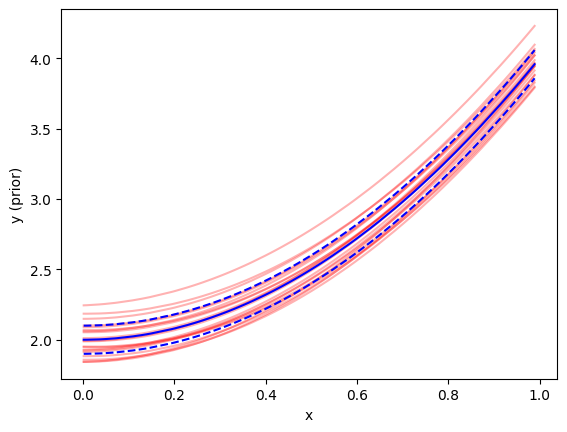

In [47]:
# optimal 
def mu(x): # optimal
    return 2*(1+x**2)
sigma_0 = 0.1 # optimal
l = 2 # optimal, 

# alternative
# def mu(x): 
#     return np.sin(x)*(1+x)+1+x**2 
# sigma_0 = 0.1 
# l = 20 #

mu_prior_test = mu(x_test)
P_prior_test = r(x_test, x_test, sigma_0, l)

sigma_prior_test = np.sqrt(np.diagonal(P_prior_test))

n_samples = 20
ys_test = stats.multivariate_normal(mean = mu_prior_test,cov = P_prior_test, allow_singular= True).rvs(n_samples)
for y in ys_test:
    plt.plot(x_test, y, '-', color = 'red', alpha = 0.3)

plt.plot(x_test, mu_prior_test, '-b')
plt.plot(x_test, mu_prior_test + sigma_prior_test, '--b')
plt.plot(x_test, mu_prior_test - sigma_prior_test, '--b')
plt.xlabel('x')
plt.ylabel('y (prior)')

## Adding data (likelihood)

In our Bayesian formulation the random-variable $\mathbf{Y} | \mathbf{d}$ (that we are trying to identify), is defined at both training- and test nodes.  Data $\mathbf{d}\in \mathbb{R}^M$ is only available at training nodes.  We need therefore:
 
1. An observation matrix $H \in \mathbb{R}^{M\times (M+N)}$, which extracts only the observed (training) values from the combined training + test vector $\mathbf{y}$.
2. The observation error matrix $R = \sigma_\epsilon^2 I\in \mathbb{R}^{M\times M}$ - whereby we assume Gaussian uncorrellated observation errors.  We assume throughout that $\sigma_\epsilon=1\times 10^{-3}$.

**EXERCISE 3**

Implement 1: There is a useful trick here: Numpy *slices*.  With the syntax `x_all[:M]` you extract the 1st `M` entries of `x_all`.  Similarly `x_all[M:]` returns all except the 1st `M` entries.  Apply this idea to an identity matrix of size $M+N$ to get a suitable matrix $H$.

Implement 2. As well as $R$, also evaluate the data $\mathbf{d} := g(\mathbf{x}_\mathrm{train}) + \epsilon$.  I.e. explicitly add a small about of noise to the observations to simulate a real measurement.  Use `stats.multivariate_normal(0*x_train, R).rvs()` to generate the noise.

In [48]:
# observation matrix
def calc_H(M,N):
     H = np.eye(M+N) 
     H = H[:M, :]
     # assert np.shape(H) == (M, M+N)
     return H


# observation error matrix
def calc_R(M, sigma_e = 1e-3):
    return sigma_e**2*np.eye(M)


def generate_d(x_all, M, N):
    H = calc_H(M,N)
    R = calc_R(M)
    e = stats.multivariate_normal(0*x_all[:M], R).rvs()
    d = H @ g(x_all) + e
    return d


In [49]:
# generate data
d = generate_d(x_all, M, N)
print(f'd-shape: {np.shape(d)}')

d-shape: (10,)


**EXERCISE 4**

Now implementing Kriging is just a question of computing the posterior pdf from Bayes rule:
$$
p( \mathbf{y} \mid \mathbf{d}) \propto p(\mathbf{d}\mid  \mathbf{y}) \cdot p_0(\mathbf{y}).
$$
Since prior and likelihood are both Gaussian, the posterior is Gaussian
$$
\mathbf{Y} \mid \mathbf{d} \sim \mathcal{N}(\hat\mu, \hat\Sigma),
$$
and we need only find the mean and covariance matrix - which is just linear algebra:
$$
\hat\mu = \mu_y + K (\mathbf{d} - H\mu_y) \\
\hat\Sigma = (I - K H) P \\
K = PH^T (R+HPH^T)^{-1}.
$$
Beware that in this formula, the prior mean $\mu_0$ and covariance $P$ should be evaluated at *all* nodes.

Plot the mean, and a few random samples from the posterior.  Compare with the true function.  [For plotting using only the test nodes is convenient.]  You should see a good fit at the training nodes, and closeby - especially where training nodes are clustered.  The fit elsewhere may be poor.  Choose reasonable values for $\mu()$ and $\sigma_0$ given what you know about the function - adjust $l$ to try to get a reasonable fit (it may be difficult without more than 10 samples!).

Text(0, 0.5, 'y (Posterior)')

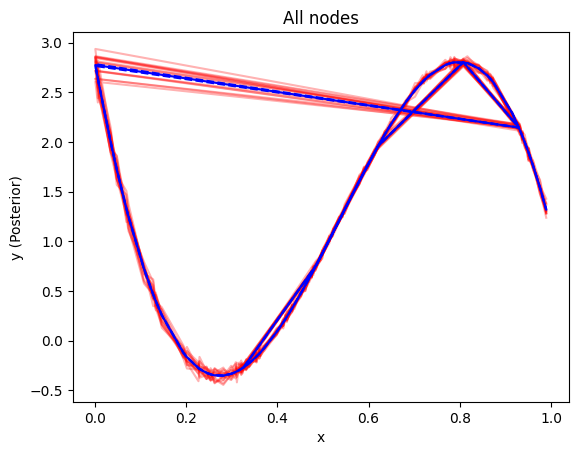

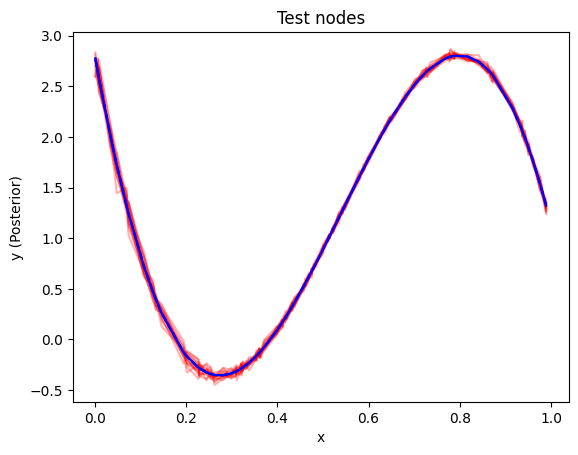

In [50]:
# # 1. optimal 
# def mu(x): # optimal
#     return  4*(2+x**2) # np.sin(x)*(1+x)+1+x**2   
# sigma_0 = 2 # optimal
# l = 1.0 # optimal

# 2. optimal 
def mu(x): # optimal
    return 2*(1+x**2)
sigma_0 = 0.5 # optimal
l = 2 # optimal, 


def calc_K(P, H, R):
    return P @ H.T @ np.linalg.inv(R + H @P @ H.T)

def calc_muPosterior(x, mu, P, H, R, d):
    K = calc_K(P, H, R)
    mu_prior = mu(x)
    # print(f'x: {np.shape(x), }mu: {np.shape(mu_prior)}, K: {np.shape(K)}, d: {np.shape(d)}, H: {np.shape(H)}') #K @ (d - H @ mu_prior: {np.shape(K @ (d - H @ mu_prior))}')
    return mu_prior + K @ (d - H @ mu_prior)


def calc_sigmaPosterior(P, H, R, M, N):
    K = calc_K(P, H, R)
    return (np.eye(np.shape(K)[0])- K @ H) @ P

y_all = g(x_all)
y_train = g(x_train)
d = generate_d(x_all, M, N)

# construct prior matrices for ALL nodes
H = calc_H(M, N) # observation matrix
R = calc_R(M) # observation error matrix
P = r(x_all, x_all, sigma_0, l) # prior covariance matrix 

# construct posterior matrices 
muPosterior = calc_muPosterior(x = x_all, mu = mu, P = P, H = H, R = R, d = d)
Sigma_Posterior = calc_sigmaPosterior(P, H, R, M, N)

Sigma_Posterior_diagonal = np.sqrt(np.diagonal(Sigma_Posterior))

# plot for all points
n_samples = 15
ys_all = stats.multivariate_normal(mean = muPosterior,cov = Sigma_Posterior_diagonal, allow_singular= True).rvs(n_samples)
for y in ys_all:
    plt.plot(x_all, y, '-', color = 'red', alpha = 0.3)

plt.plot(x_all, muPosterior, '-b')
plt.plot(x_all, muPosterior + Sigma_Posterior_diagonal, '--b')
plt.plot(x_all, muPosterior - Sigma_Posterior_diagonal, '--b')
plt.title('All nodes')
plt.xlabel('x')
plt.ylabel('y (Posterior)')

# plot for only test points
n_samples = 15
muPosterior_test = muPosterior[M:]
Sigma_Posterior_diagonal_test = Sigma_Posterior_diagonal[M:]

ys_test = stats.multivariate_normal(mean = muPosterior_test,cov = Sigma_Posterior_diagonal_test, allow_singular= True).rvs(n_samples)
plt.figure()
for y in ys_test:
    plt.plot(x_test, y, '-', color = 'red', alpha = 0.3)

plt.plot(x_test, muPosterior_test, '-b')
plt.plot(x_test, muPosterior_test + Sigma_Posterior_diagonal_test, '--b')
plt.plot(x_test, muPosterior_test - Sigma_Posterior_diagonal_test, '--b')
plt.title('Test nodes')
plt.xlabel('x')
plt.ylabel('y (Posterior)')


**EXERCISE 5**

Take your code so far, and (without much modification), put in a form which can be called in the following way.  Check results are similar to your previous code.

In [51]:
def kriging(M, N, x, d, mu, sigma_0 = 1.082548228747729, sigma_epsilon = 1e-3, l = 1):
    """
    Kriging in 1-dimension for a single variable - following the
    Bayesian derivation and notation.
    
    Arguments:
      M,N [integers]: Number of training-, test-nodes.
      x [array (M+N)]: Node locations (both observations and predictions)
      d [array (M)]: Nodal observations ("data")
      mu [function]: Mean of prior.
      sigma_0 [float]: Standard-deviation of the prior.
      sigma_epsilon [float]: Standard-deviation of observation error.
      l [float]: Correlation length.
    Return:
      muhat [array (M+N)]: Posterior mean
      Sigmahat [array (M+N,M+N)]: Posterior covariance.
    """
    H = calc_H(M, N)# H = calc_H(x, d, M, N)
    R = calc_R(M)
    P = r(x, x, sigma_0, l)

    muhat = calc_muPosterior(x, mu, P = P, H = H, R = R, d = d)
    Sigmahat = calc_sigmaPosterior(P, H, R, M, N)
    return muhat, Sigmahat
    

Text(0, 0.5, 'y (Posterior)')

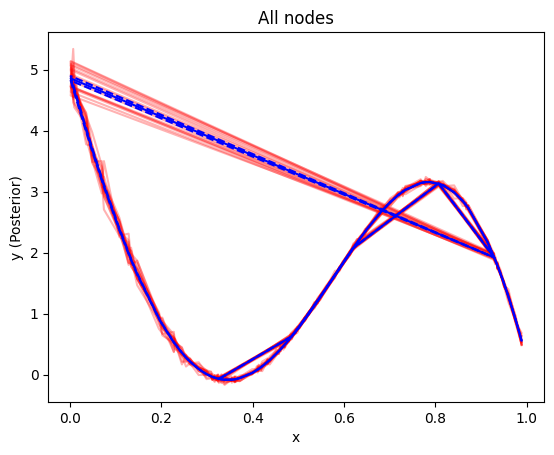

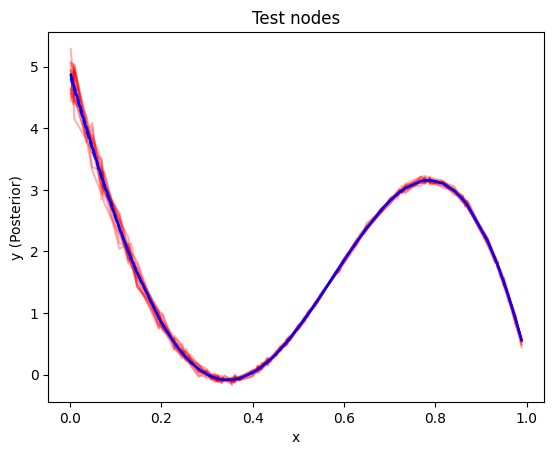

In [52]:
muhat, Sigmahat = kriging(x = x_all, d = d, M = 10, N = 100, mu = mu, sigma_0 = 0.75, sigma_epsilon = 1e-3, l = 1.0)

Sigmahat_diagonal = np.sqrt(np.diagonal(Sigmahat))

# plot for all points
n_samples = 15
ys_all = stats.multivariate_normal(mean = muhat,cov = Sigmahat_diagonal, allow_singular= True).rvs(n_samples)
for y in ys_all:
    plt.plot(x_all, y, '-', color = 'red', alpha = 0.3)

plt.plot(x_all, muhat, '-b')
plt.plot(x_all, muhat + Sigmahat_diagonal, '--b')
plt.plot(x_all, muhat - Sigmahat_diagonal, '--b')
plt.title('All nodes')
plt.xlabel('x')
plt.ylabel('y (Posterior)')

# plot for only test points
n_samples = 15
muhat_test = muhat[M:]
Sigmahat_diagonal_test = Sigmahat_diagonal[M:]

ys_test = stats.multivariate_normal(mean = muhat_test,cov = Sigmahat_diagonal_test, allow_singular= True).rvs(n_samples)
plt.figure()
for y in ys_test:
    plt.plot(x_test, y, '-', color = 'red', alpha = 0.3)

plt.plot(x_test, muhat_test, '-b')
plt.plot(x_test, muhat_test + Sigmahat_diagonal_test, '--b')
plt.plot(x_test, muhat_test - Sigmahat_diagonal_test, '--b')
plt.title('Test nodes')
plt.xlabel('x')
plt.ylabel('y (Posterior)')


## Convergence study
**EXERCISE 6**

The most basic thing we require from numerical methods is *convergence*.  The following code will test the convergence of your `kriging()` function.  For an error measure the RMSE w.r.t. the kriging mean, at the test nodes is used:
$$
\epsilon := \sqrt{\frac{1}{N}\sum_{i=1}^N (g(\mathbf{x}_i) - \hat\mu(\mathbf{x}_i))^2}
$$
Both training and test-nodes are uniformly spaced to reduce noise.  You can see the variability in convergence by running `convergence_study()` multiple times in the cell below, which will add more lines to the same graph.

Which of the 3 parameters $\mu$, $\sigma_0$, $l$ is the most important for the convergence rate and absolute error?  What happens to the converenge for large values of $M$?  It should approach a constant *rate*? (I.e. straight-line in log-log plot.)  Is this rate familiar?  Why is does this rate result eventually?


-------


$l$ seems to be the most important for convergence rate/absolute error. A smaller $l$ results in faster convergence rates than larger $l$- that assume more correlation between farther data points. 

For large values of M, there is a change from spectral convergence (similar to that of stochastic polynomial interpolation) to a constant convergence rate (similar to that of Monte-Carlo). 



Convergence rate = 0.6595
Convergence rate = 0.5023
Convergence rate = 0.3749
Convergence rate = 0.009046


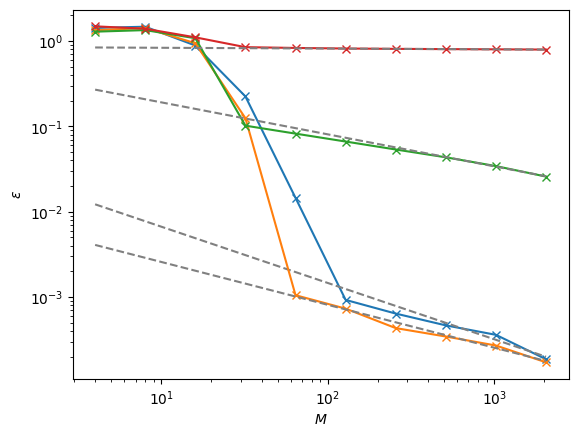

In [53]:
# Convergence study
def mu(x):
    return 2*(1+x**2)   # np.sin(c*x*x)*(1+x)+1+x**2 #TODO pick a reasonable prior
sigma_0 = 0.5 #1.5 #0.1082548228747729 # TODO pick a reasonable std. dev
l = 0.1 # TODO pick a reasonable correlation length
sigma_epsilon = 1.e-3

def convergence_study(mu, sigma_0, sigma_epsilon, l):
    N = 1000
    # Ms = 2**np.arange(2,12,dtype=np.int)
    Ms = 2**np.arange(2,12,dtype=int)
    err_M = np.zeros(len(Ms))
    for j,M in enumerate(Ms):
        x = np.hstack((np.linspace(0,1,M), np.linspace(0,1,N)))
        d = g(x[:M]) + stats.multivariate_normal(np.zeros(M), np.identity(M)*sigma_epsilon**2).rvs()
        muhat,_ = kriging(M, N, x, d, mu, sigma_0, sigma_epsilon, l)
        err_M[j] += np.sqrt(np.sum((g(x[M:]) - muhat[M:])**2)/N)

    plt.loglog(Ms, err_M, 'x-')

    plt.xlabel(r'$M$')
    plt.ylabel(r'$\epsilon$')
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(np.log10(Ms)[-3:], np.log10(err_M)[-3:])
    print("Convergence rate = %.4g" % -slope)
    plt.loglog(Ms, 10**(intercept + slope*np.log10(Ms)), '--', color='0.5')   

    
convergence_study(mu, sigma_0, sigma_epsilon, l/4)
convergence_study(mu, sigma_0, sigma_epsilon, l/2)
convergence_study(mu, sigma_0, sigma_epsilon, l)
convergence_study(mu, sigma_0, sigma_epsilon, 2*l)
